# Training machine learning model for melting point of ionic liquids prediction

In [1]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from rdkit.Chem import Descriptors
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import shap

2024-05-28 17:37:58.097561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 17:37:58.969099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read dataset

In [2]:
df = pd.read_csv('dataset_for_melting_point_ML_model.csv')
cation = list(df.loc[:, 'cation'])
anion = list(df.loc[:, 'anion'])
smiles = list(df['smiles'])

Ys = list(df.loc[:, 'Tm'])

### Calculate descriptors

In [22]:
def getMolDescriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    res = []
    for nm, fn in Descriptors._descList:
        res.append(fn(mol))
    return res

def smiles_to_MACCS(smi): 
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.array(fp, float)
    return fp

Des_cation = np.array([getMolDescriptors(c) for c in cation])
Des_anion = np.array([getMolDescriptors(a) for a in anion])
fp_anion = np.array([smiles_to_MACCS(a) for a in anion])
fp_cation = np.array([smiles_to_MACCS(c) for c in cation])
X = np.c_[fp_cation, Des_cation, fp_anion, Des_anion]
Y = np.array(Ys).reshape(len(Ys), 1)

### Split traning set and testing set

In [157]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### Random forest (RF) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2_test=0.863149
MSE_test=123.352964


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


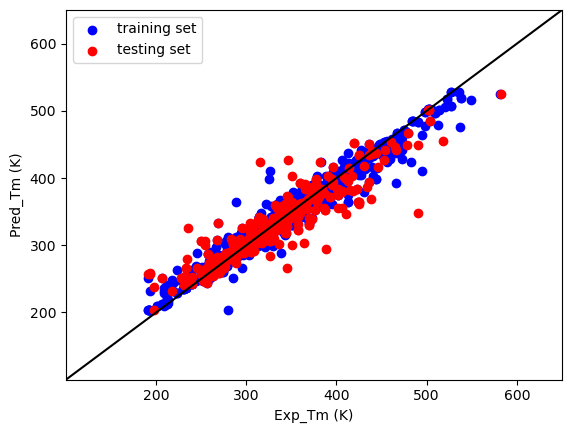

In [158]:
regr = RandomForestRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
MSE_test = mean_squared_error(Y_train, Y_train_pred)
plt.figure()
plt.xlabel("Exp_Tm (K)")
plt.ylabel("Pred_Tm (K)")
plt.plot([100.1, 650.1], [100.1, 650.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([100.1, 650.1])
plt.ylim([100.1, 650.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('MSE_test=%f'%MSE_test)

Interpret RF regression model using SHAP

PermutationExplainer explainer: 457it [13:59,  1.85s/it]                         


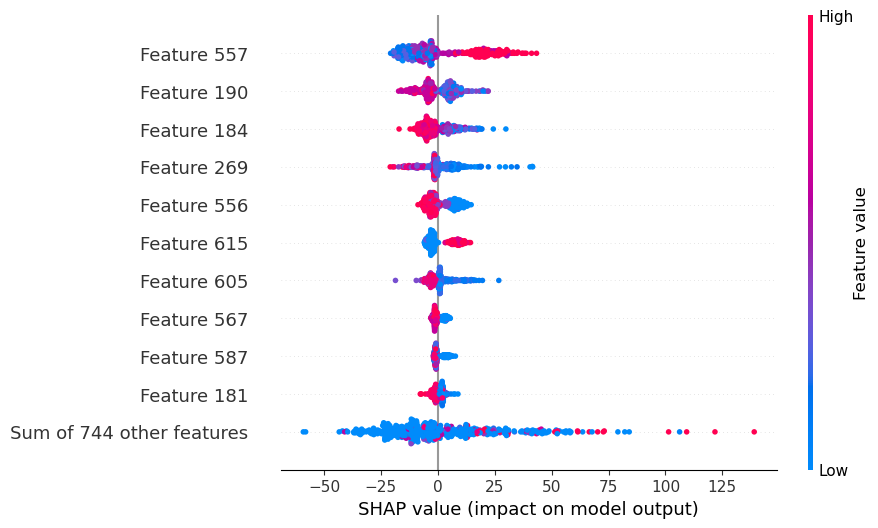

In [6]:
explainer = shap.Explainer(regr.predict, X_train, seed=1)
shap_values = explainer(X_test, max_evals=2000)
shap.plots.beeswarm(shap_values, max_display=11)

corss validation

In [159]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y))
for train_index, test_index in kf.split(X, Y):
    regr = RandomForestRegressor(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

R2:  0.8579431839586223
MSE:  523.0885842591


### Extreme gradient boosting (XGBoost) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R^2_test=0.733078
MSE_test=635.511628


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


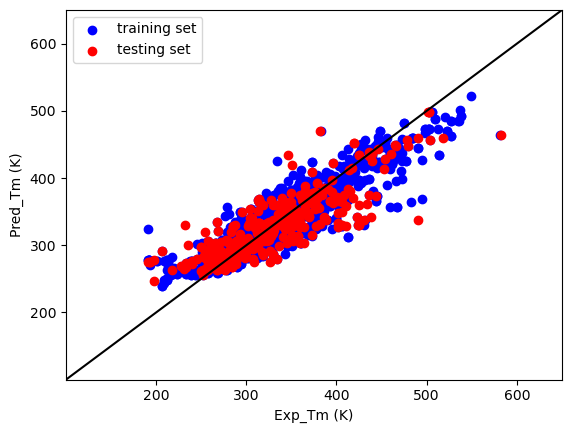

In [160]:
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
MSE_test = mean_squared_error(Y_train, Y_train_pred)
plt.figure()
plt.xlabel("Exp_Tm (K)")
plt.ylabel("Pred_Tm (K)")
plt.plot([100.1, 650.1], [100.1, 650.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([100.1, 650.1])
plt.ylim([100.1, 650.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('MSE_test=%f'%MSE_test)

cross validation

In [161]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y))
for train_index, test_index in kf.split(X, Y):
    regr = GradientBoostingRegressor(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

R2:  0.750320180011697
MSE:  919.3832946228109


### Ridge regression

Ill-conditioned matrix (rcond=1.88089e-24): result may not be accurate.
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


R^2_test=0.600715
MSE_test=945.033975


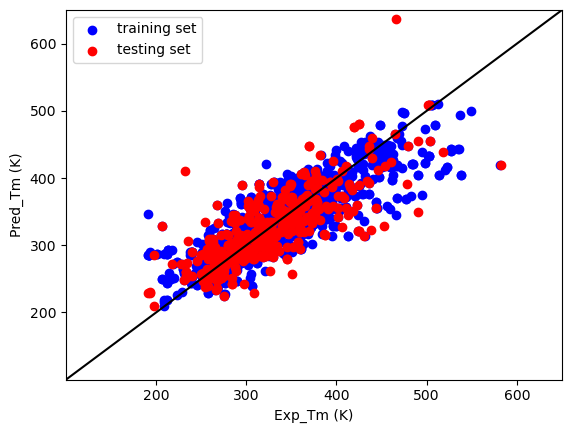

In [162]:
regr = Ridge(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
MSE_test = mean_squared_error(Y_train, Y_train_pred)
plt.figure()
plt.xlabel("Exp_Tm (K)")
plt.ylabel("Pred_Tm (K)")
plt.plot([100.1, 650.1], [100.1, 650.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([100.1, 650.1])
plt.ylim([100.1, 650.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('MSE_test=%f'%MSE_test)

cross validation

In [163]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y)).reshape(-1,1)
for train_index, test_index in kf.split(X, Y):
    regr = Ridge(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

Ill-conditioned matrix (rcond=5.63943e-24): result may not be accurate.
Ill-conditioned matrix (rcond=2.84912e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.88168e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.85458e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.87688e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.88668e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.88948e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.89828e-24): result may not be accurate.
Ill-conditioned matrix (rcond=1.8884e-24): result may not be accurate.


R2:  0.6274044385156021
MSE:  1371.989674197178


Ill-conditioned matrix (rcond=1.89916e-24): result may not be accurate.


### Artificial neural network (ANN) model

normolize X

In [137]:
X_max_matrix = X.max(axis=0)
X_min_matrix = X.min(axis=0)
diff_matrix = X_max_matrix - X_min_matrix
for i in range(len(diff_matrix)):
    if diff_matrix[i] == 0:
        diff_matrix[i] = 1

X_normalized = (X - X_min_matrix) / diff_matrix
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=1)

training model

In [150]:
keras.utils.set_random_seed(1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

model = keras.models.Sequential()
model.add(keras.layers.Dense(units=754, input_shape=(None, 754), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=754, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.compile(loss='MAE', optimizer=tf.keras.optimizers.Adam(0.0001))
model.fit(X_train, Y_train,  epochs=500)

Epoch 1/500
57/57 [==============================] - 1s 2ms/step - loss: 314.5511
Epoch 2/500
57/57 [==============================] - 0s 2ms/step - loss: 195.4173
Epoch 3/500
57/57 [==============================] - 0s 2ms/step - loss: 75.9007
Epoch 4/500
57/57 [==============================] - 0s 2ms/step - loss: 59.8550
Epoch 5/500
57/57 [==============================] - 0s 2ms/step - loss: 52.1082
Epoch 6/500
57/57 [==============================] - 0s 2ms/step - loss: 46.5233
Epoch 7/500
57/57 [==============================] - 0s 2ms/step - loss: 44.6092
Epoch 8/500
57/57 [==============================] - 0s 2ms/step - loss: 42.2351
Epoch 9/500
57/57 [==============================] - 0s 2ms/step - loss: 40.1563
Epoch 10/500
57/57 [==============================] - 0s 2ms/step - loss: 39.3083
Epoch 11/500
57/57 [==============================] - 0s 2ms/step - loss: 37.4701
Epoch 12/500
57/57 [==============================] - 0s 2ms/step - loss: 36.7936
Epoch 13/500
57/57 [===

testing model

57/57 [==============================] - 0s 1ms/step
R^2_test=0.763623
mse_test=840.658172


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


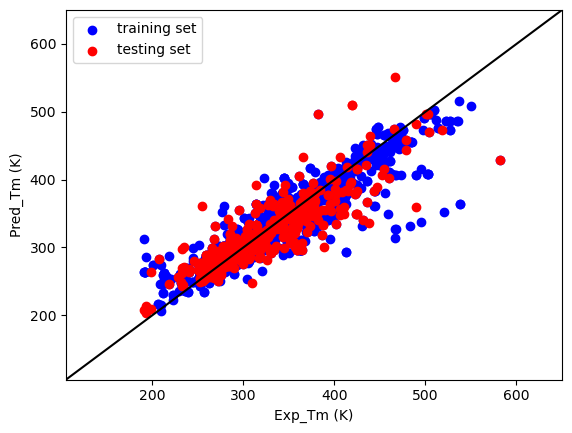

In [151]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_Tm (K)")
plt.ylabel("Pred_Tm (K)")
plt.plot([105.1, 650.1], [105.1, 650.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([105.1, 650.1])
plt.ylim([105.1, 650.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

cross validation

In [156]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y)).reshape(-1,1)
for train_index, test_index in kf.split(X_normalized, Y):
    keras.utils.set_random_seed(1)
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=754, input_shape=(None, 754), activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=754, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='MAE', optimizer=tf.keras.optimizers.Adam(0.0001))

    model.fit(X_normalized[train_index], Y[train_index], epochs=500)
    pred[test_index] = model.predict(X_normalized[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

Epoch 1/500
64/64 [==============================] - 1s 2ms/step - loss: 310.5174
Epoch 2/500
64/64 [==============================] - 0s 1ms/step - loss: 162.6665
Epoch 3/500
64/64 [==============================] - 0s 1ms/step - loss: 70.5250
Epoch 4/500
64/64 [==============================] - 0s 1ms/step - loss: 55.8148
Epoch 5/500
64/64 [==============================] - 0s 1ms/step - loss: 49.2538
Epoch 6/500
64/64 [==============================] - 0s 1ms/step - loss: 44.8671
Epoch 7/500
64/64 [==============================] - 0s 1ms/step - loss: 42.3229
Epoch 8/500
64/64 [==============================] - 0s 1ms/step - loss: 40.3837
Epoch 9/500
64/64 [==============================] - 0s 1ms/step - loss: 39.0514
Epoch 10/500
64/64 [==============================] - 0s 1ms/step - loss: 38.1062
Epoch 11/500
64/64 [==============================] - 0s 2ms/step - loss: 36.9639
Epoch 12/500
64/64 [==============================] - 0s 1ms/step - loss: 36.1304
Epoch 13/500
64/64 [===